# Feature Engineering

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import xgboost as xgb
from xgboost import plot_importance
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load dataframe
loans = pd.read_csv('./data/final.df.csv', low_memory=False)

loans = loans[(loans['loan_status'] == 'Fully Paid') | (loans['loan_status'] == 'Charged Off') | (loans['loan_status'] == 'Default')]
loans = loans.assign(paid_flag = np.where(loans['loan_status'].str.contains('Fully Paid'), 1, 0))

# Yan's selection
features = ['loan_amnt','int_rate','installment','annual_inc','dti','grade','home_ownership',\
            'total_acc','open_acc','pub_rec','revol_bal','revol_util','mort_acc','paid_flag',\
            'mo_sin_old_il_acct','mo_sin_old_rev_tl_op']

loans = loans[features] #16 features with target var
loans = loans.reset_index(drop=True)

In [3]:
# under sampling
# loans_paid = loans[loans['paid_flag'] == 1].sample(int(len(loans) * 0.2))
# loans_default = loans[loans['paid_flag'] == 0]
# loans = pd.concat([loans_paid, loans_default])

print(loans['paid_flag'].value_counts())

pd.set_option('display.max_columns', 200)
loans.head(5)

1    107725
0     92275
Name: paid_flag, dtype: int64


,loan_amnt,int_rate,installment,annual_inc,dti,grade,home_ownership,total_acc,open_acc,pub_rec,revol_bal,revol_util,mort_acc,paid_flag,mo_sin_old_il_acct,mo_sin_old_rev_tl_op
0,12000,9.17,382.55,85000.0,7.54,B,MORTGAGE,21,12,0,11299,65.3,2,1,173,442
1,10000,8.90,317.54,40000.0,27.60,A,RENT,16,13,0,11117,86.2,0,1,91,84
2,8000,9.99,258.10,40000.0,31.89,B,RENT,18,11,0,15173,39.2,0,1,96,180
3,3600,16.99,128.34,96000.0,23.19,D,MORTGAGE,49,31,0,7645,51.3,7,1,147,50
4,34600,10.56,1125.57,53000.0,29.10,B,MORTGAGE,28,13,0,6570,11.0,0,1,204,104


In [4]:
# dummify
target = loans['paid_flag']
loans = loans.drop(['paid_flag'], axis=1)

print('before dummify: ' + str(loans.shape))

loans = pd.get_dummies(loans, drop_first=True)
loans_norm = preprocessing.normalize(loans)

print('after dummify: ' + str(loans.shape))

# seprate training & test set
X_train, X_test, Y_train, Y_test = train_test_split(loans_norm, target, shuffle=True, test_size=0.2)

before dummify: (200000, 15)
after dummify: (200000, 24)


# Modeling

### 1. Logistic Regression

In [5]:
logit = linear_model.LogisticRegression(solver='liblinear', max_iter=1000)

param = dict(C=[0.001, 0.01, 0.1, 1, 10, 100, 1000], penalty=['l1', 'l2'])

logit_grid = GridSearchCV(logit, param, cv=5, verbose=0, n_jobs=-1)

best_mdl = logit_grid.fit(X_train, Y_train)

# best hyperparameter
print('best hyperparameter')
print(best_mdl.best_estimator_.get_params())
print()

# best cross-validation score
print('best cross-validation score: ' + str(best_mdl.score(X_train, Y_train)))
print()

Y_pred = logit_grid.predict(X_test)

rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

best hyperparameter
{'C': 1000, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

best cross-validation score: 0.64106875

Root Mean Square Error: 0.5994789404140899

Accuracy: 0.640625

[[ 9278  9253]
 [ 5122 16347]]


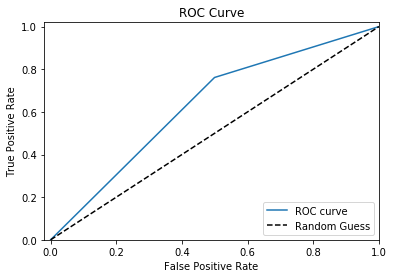

In [6]:
# visualize ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')

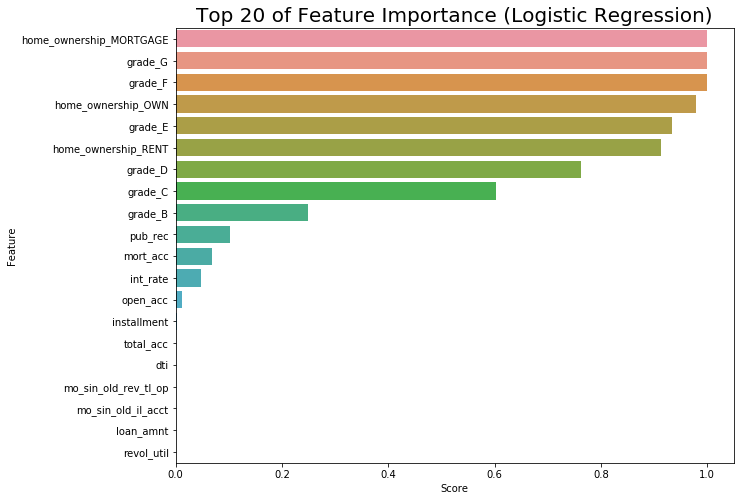

In [7]:
# visualize feature importance
feature_importance = abs(logit_grid.best_estimator_.coef_[0])
feature_importance = feature_importance / feature_importance.max()

plt.figure(figsize=(10, 8))
importances = pd.DataFrame(data={'feature':loans.columns, 'score':feature_importance})
importances = importances.sort_values(by='score', ascending=False)
importances = importances[0:20]

sns.barplot(y=importances['feature'], x=importances['score']).set_title('Top 20 of Feature Importance (Logistic Regression)', fontsize=20)
plt.xlabel("Score")
plt.ylabel("Feature")

plt.show()

### 2. Support Vector Classification

In [8]:
svc_mdl = LinearSVC()

param = {}

svc_grid = GridSearchCV(svc_mdl, param, cv=5, verbose=0, n_jobs=-1)

best_mdl = svc_grid.fit(X_train, Y_train)

# best hyperparameter
print('best hyperparameter')
print(best_mdl.best_estimator_.get_params())
print()

# best cross-validation score
print('best cross-validation score: ' + str(best_mdl.score(X_train, Y_train)))
print()

Y_pred = svc_grid.predict(X_test)

rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

best hyperparameter
{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}

best cross-validation score: 0.584425

Root Mean Square Error: 0.6451356446515725

Accuracy: 0.5838

[[ 7441 11090]
 [ 5558 15911]]


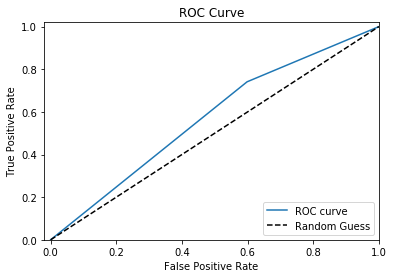

In [9]:
# visualize ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')

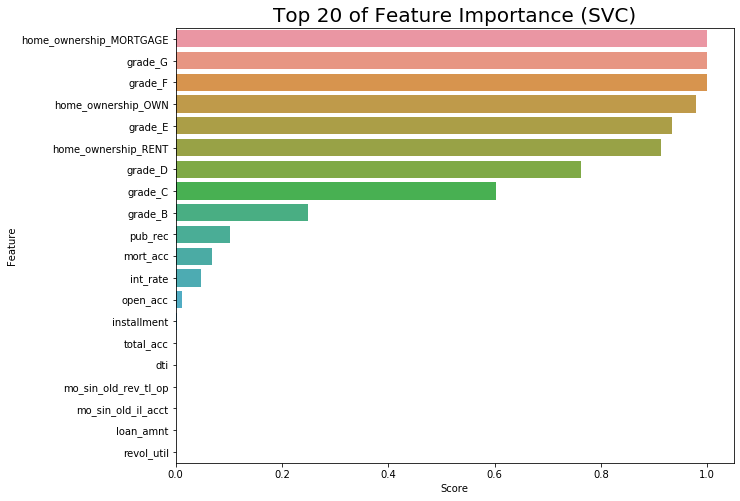

In [10]:
# visualize feature importance
feature_importance = abs(logit_grid.best_estimator_.coef_[0])
feature_importance = feature_importance / feature_importance.max()

plt.figure(figsize=(10, 8))
importances = pd.DataFrame(data={'feature':loans.columns, 'score':feature_importance})
importances = importances.sort_values(by='score', ascending=False)
importances = importances[0:20]

sns.barplot(y=importances['feature'], x=importances['score']).set_title('Top 20 of Feature Importance (SVC)', fontsize=20)
plt.xlabel("Score")
plt.ylabel("Feature")

plt.show()

### 3. XGBoost

In [11]:
xgb_mdl = xgb.XGBClassifier(eval_metric='error', objective='binary:logistic')

param = dict(learning_rate=[0.01, 0.1, 0.5],
             max_depth=[3, 6, 9],
             n_estimators=[100, 500, 1000],
             gamma=[0, 0.1, 1],
             min_child_weight=[1, 3, 5])

xgb_grid = GridSearchCV(xgb_mdl, param, n_jobs=-1, cv=5, verbose=0)

best_mdl = xgb_grid.fit(X_train, Y_train)

# best hyperparameter
print('best hyperparameter')
print(best_mdl.best_estimator_.get_params())
print()

# best cross-validation score
print('best cross-validation score: ' + str(best_mdl.score(X_train, Y_train)))
print()

Y_pred = xgb_grid.predict(X_test)

rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

best hyperparameter
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 9, 'min_child_weight': 3, 'missing': None, 'n_estimators': 1000, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'eval_metric': 'error'}

best cross-validation score: 0.87239375

Root Mean Square Error: 0.5979757520167519

Accuracy: 0.642425

[[10791  7740]
 [ 6563 14906]]


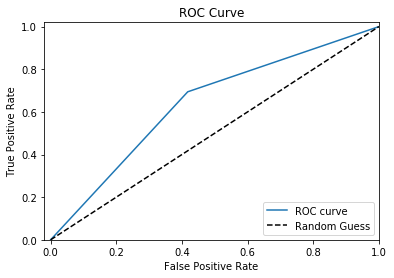

In [12]:
# visualize ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')

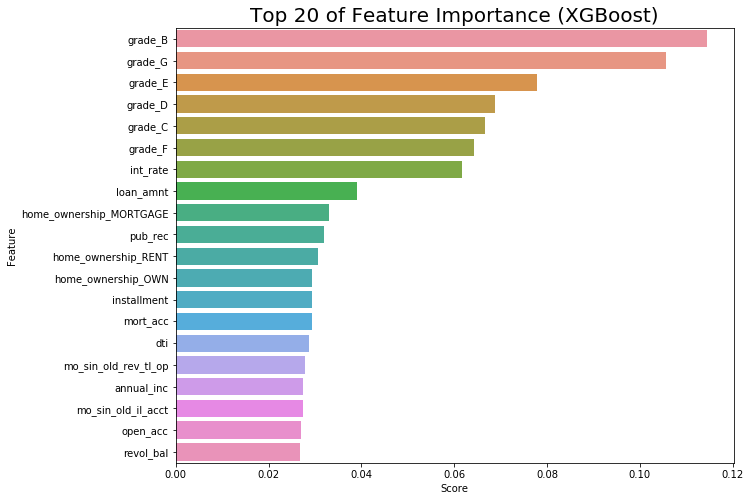

In [13]:
# visualize feature importance
plt.figure(figsize=(10, 8))
importances = pd.DataFrame(data={'feature':loans.columns, 'score':best_mdl.best_estimator_.feature_importances_})
importances = importances.sort_values(by='score', ascending=False)
importances = importances[0:20]

sns.barplot(y=importances['feature'], x=importances['score']).set_title('Top 20 of Feature Importance (XGBoost)', fontsize=20)
plt.xlabel("Score")
plt.ylabel("Feature")

plt.show()

### 4. Random Forest

In [14]:
rf_mdl = RandomForestClassifier()
param = { 
    'n_estimators': [100, 500, 1000],
    'criterion' :['entropy', 'gini']
}

rf_grid = GridSearchCV(rf_mdl, param, cv= 5, verbose=0, n_jobs=-1)

best_mdl = rf_grid.fit(X_train, Y_train)

# best hyperparameter
print('best hyperparameter')
print(best_mdl.best_estimator_.get_params())
print()

# best cross-validation score
print('best cross-validation score: ' + str(best_mdl.score(X_train, Y_train)))
print()

Y_pred = rf_grid.predict(X_test)

rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

best hyperparameter
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

best cross-validation score: 1.0

Root Mean Square Error: 0.5937381577766414

Accuracy: 0.647475

[[10813  7718]
 [ 6383 15086]]


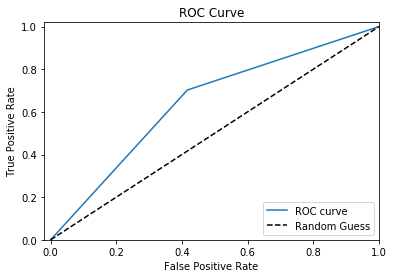

In [15]:
# visualize ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')

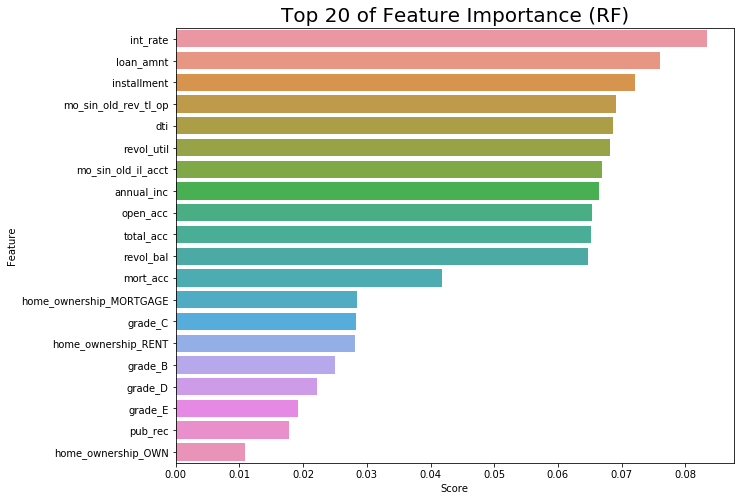

In [16]:
# visualize feature importance
plt.figure(figsize=(10, 8))
importances = pd.DataFrame(data={'feature':loans.columns, 'score':best_mdl.best_estimator_.feature_importances_})
importances = importances.sort_values(by='score', ascending=False)
importances = importances[0:20]

sns.barplot(y=importances['feature'], x=importances['score']).set_title('Top 20 of Feature Importance (RF)', fontsize=20)
plt.xlabel("Score")
plt.ylabel("Feature")

plt.show()

### 5. Gradient Boosting Classifier

In [18]:
gbc_mdl = GradientBoostingClassifier()
param = {
    'learning_rate': [0.1, 0.5],
    'n_estimators': [100, 1000]
}

gbc_grid = GridSearchCV(gbc_mdl, param, cv= 5, verbose=0, n_jobs=-1)

best_mdl = gbc_grid.fit(X_train, Y_train)

# best hyperparameter
print('best hyperparameter')
print(best_mdl.best_estimator_.get_params())
print()

# best cross-validation score
print('best cross-validation score: ' + str(best_mdl.score(X_train, Y_train)))
print()

Y_pred = gbc_grid.predict(X_test)

rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

best hyperparameter
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

best cross-validation score: 0.673075

Root Mean Square Error: 0.590042371359888

Accuracy: 0.65185

[[10894  7637]
 [ 6289 15180]]


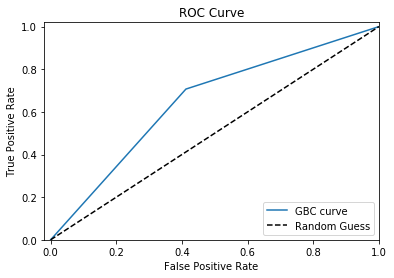

In [19]:
# visualize ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

plt.plot(fpr, tpr, label='GBC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')

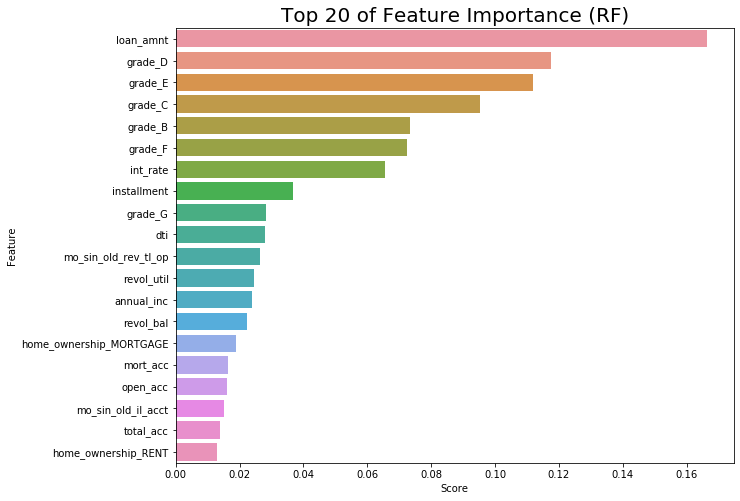

In [20]:
# visualize feature importance
plt.figure(figsize=(10, 8))
importances = pd.DataFrame(data={'feature':loans.columns, 'score':best_mdl.best_estimator_.feature_importances_})
importances = importances.sort_values(by='score', ascending=False)
importances = importances[0:20]

sns.barplot(y=importances['feature'], x=importances['score']).set_title('Top 20 of Feature Importance (RF)', fontsize=20)
plt.xlabel("Score")
plt.ylabel("Feature")

plt.show()

# Stacking Models

In [21]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=500, criterion='entropy')),
    ('xgb', xgb.XGBClassifier(learning_rate=0.1, n_estimators=500, max_depth=9, eval_metric='error', objective='binary:logistic')),
    ('gbc', GradientBoostingClassifier(learning_rate=0.1, n_estimators=500))
]

sc = StackingClassifier(cv=5, n_jobs=-1, estimators=estimators,
                        final_estimator=linear_model.LogisticRegression())

sc.fit(X_train, Y_train)

Y_pred = sc.predict(X_test)

rmse = sqrt(mean_squared_error(Y_test, Y_pred))

print('Root Mean Square Error: ' + str(rmse))
print()

print('Accuracy: ' + str(np.mean(Y_test == Y_pred)))
print()

print(confusion_matrix(Y_test, Y_pred))

Root Mean Square Error: 0.5886212704277684

Accuracy: 0.653525

[[10937  7594]
 [ 6265 15204]]


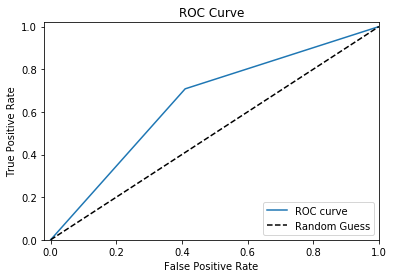

In [22]:
# visualize ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')